# Gender Convergence in Household Work: A 20-Year Analysis (2002–2022)

This notebook tests three hypotheses about gender convergence in household work and egalitarian attitudes using harmonized ISSP data.

## 1. Imports & Configuration

In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, pearsonr, spearmanr, linregress, sem
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')
os.chdir('/Users/ashishpapanai/Desktop/MS_Tübingen/ML4102')
from tueplots import bundles
from tueplots import figsizes, fontsizes
plt.rcParams.update(bundles.icml2024())
USE_TUEPLOTS = True
# Set color palette
COLOR_PALETTE = {
    'Male': '#56B4E9',
    'Female': '#f678a7',
    'neutral': '#029E73'
}

print("Setup done")


Setup done


## 2. Clean Data Construction

Load and harmonize data from `final_csv/` directory. All variables from the reference notebook are retained.

In [20]:
# Load data from final_csv directory
data_frames = []
for year in [2002, 2012, 2022]:
    df = pd.read_csv(f'final_csv/{year}.csv')
    df['year'] = year
    data_frames.append(df)

# Concatenate all years
df_all = pd.concat(data_frames, ignore_index=True)

print(f"Loaded {len(df_all):,} observations")
print(f"Years: {sorted(df_all['year'].unique())}")
print(f"Variables: {len(df_all.columns)}")


Loaded 154,154 observations
Years: [np.int64(2002), np.int64(2012), np.int64(2022)]
Variables: 89


In [21]:
# Clean and standardize key variables

# 1. Equality score (eg_score_norm)
df_all['eg_score_norm'] = pd.to_numeric(
    df_all['eg_score_norm'].astype(str).str.replace(',', '.', regex=False),
    errors='coerce'
)

# 2. Household work hours and related variables
numeric_vars = ['hh_wrk_hrs', 'SP_HH', 'HOMPOP', 'age', 'wrk_hrs', 'SPWRKHRS']
for var in numeric_vars:
    if var in df_all.columns:
        df_all[var] = pd.to_numeric(
            df_all[var].astype(str).str.replace(',', '.', regex=False),
            errors='coerce'
        )

# 3. Standardize gender variable
df_all['sex'] = df_all['sex'].astype(str).str.strip().str.title()

# 4. Country variable
if 'country' in df_all.columns:
    df_all['country'] = df_all['country'].astype(str).str.strip().str.upper()
elif 'COUNTRY' in df_all.columns:
    df_all['country'] = df_all['COUNTRY'].astype(str).str.strip().str.upper()

print("Variables cleaned")


Variables cleaned


In [22]:
# Create analysis dataset with necessary filters
analysis_data = df_all[
    (df_all['sex'].isin(['Male', 'Female'])) &
    (df_all['hh_wrk_hrs'].notna()) &
    (df_all['SP_HH'].notna()) &
    (df_all['eg_score_norm'].notna())
].copy()

print(f"\nAnalysis sample")
print(f"N = {len(analysis_data):,}")
print(f"Years: {sorted(analysis_data['year'].unique())}")
print(f"Countries: {analysis_data['country'].nunique()}")
print(f"\nBy year:")
for year in [2002, 2012, 2022]:
    n = len(analysis_data[analysis_data['year'] == year])
    n_male = len(analysis_data[(analysis_data['year'] == year) & (analysis_data['sex'] == 'Male')])
    n_female = len(analysis_data[(analysis_data['year'] == year) & (analysis_data['sex'] == 'Female')])
    print(f"  {year}: n={n:,} (M={n_male:,}, F={n_female:,})")



Analysis sample
N = 88,214
Years: [np.int64(2002), np.int64(2012), np.int64(2022)]
Countries: 52

By year:
  2002: n=27,677 (M=12,660, F=15,017)
  2012: n=34,860 (M=17,102, F=17,758)
  2022: n=25,677 (M=12,364, F=13,313)


## 3. H1: Convergence of Male and Female Household Work

**Research Question:** Have household work hours become more equal between genders over time?

**Estimand:** Gender gap in household work hours = E[hours|Female] - E[hours|Male]

**H₀:** No significant change in gender gap over time (β_time = 0)

**H₁:** Gender gap decreases significantly over time (β_time < 0)

In [23]:
# Calculate gender gap for each year
h1_results = []

for year in [2002, 2012, 2022]:
    year_data = analysis_data[analysis_data['year'] == year]
    
    male_hrs = year_data[year_data['sex'] == 'Male']['hh_wrk_hrs'].dropna()
    female_hrs = year_data[year_data['sex'] == 'Female']['hh_wrk_hrs'].dropna()
    
    # Means and standard errors
    male_mean, male_std = male_hrs.mean(), male_hrs.std()
    female_mean, female_std = female_hrs.mean(), female_hrs.std()
    male_se = sem(male_hrs)
    female_se = sem(female_hrs)
    
    # Gender gap
    gap = female_mean - male_mean
    gap_se = np.sqrt(male_se**2 + female_se**2)
    gap_ci = (gap - 1.96*gap_se, gap + 1.96*gap_se)
    
    # T-test
    t_stat, p_value = ttest_ind(female_hrs, male_hrs)
    
    # Cohen's d
    pooled_std = np.sqrt(((len(male_hrs)-1)*male_std**2 + (len(female_hrs)-1)*female_std**2) / 
                         (len(male_hrs) + len(female_hrs) - 2))
    cohens_d = gap / pooled_std
    
    h1_results.append({
        'Year': year,
        'Male_Mean': male_mean,
        'Male_SE': male_se,
        'Female_Mean': female_mean,
        'Female_SE': female_se,
        'Gap': gap,
        'Gap_CI_Lower': gap_ci[0],
        'Gap_CI_Upper': gap_ci[1],
        'T_Stat': t_stat,
        'P_Value': p_value,
        'Cohens_D': cohens_d,
        'N_Male': len(male_hrs),
        'N_Female': len(female_hrs)
    })

h1_df = pd.DataFrame(h1_results)

print(f"\nH1: Gender gap in household work hours")
print(h1_df[['Year', 'Male_Mean', 'Female_Mean', 'Gap', 'Gap_CI_Lower', 'Gap_CI_Upper', 'P_Value', 'Cohens_D']].to_string(index=False))



H1: Gender gap in household work hours
 Year  Male_Mean  Female_Mean       Gap  Gap_CI_Lower  Gap_CI_Upper  P_Value  Cohens_D
 2002   9.008136    21.200240 12.192104     11.880852     12.503356      0.0  0.894870
 2012  10.388259    19.815013  9.426754      9.154106      9.699403      0.0  0.721781
 2022  11.086542    17.336513  6.249972      5.947709      6.552234      0.0  0.501437


In [24]:
# Test linear trend in gender gap
years = h1_df['Year'].values
gaps = h1_df['Gap'].values

slope, intercept, r_value, p_value, std_err = linregress(years, gaps)

print(f"\nLinear trend test: is gap converging?")
print(f"Gap = {slope:.4f} × Year + {intercept:.2f}")
print(f"Slope: {slope:.4f} hrs/year (SE = {std_err:.4f})")
print(f"R²: {r_value**2:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"\nResult:")
if p_value < 0.05:
    direction = "decreasing" if slope < 0 else "increasing"
    print(f"  Significant {direction} trend (p={p_value:.4f})")
    print(f"  Gap changes by {slope:.3f} hrs/year")
else:
    print(f"  No significant trend (p={p_value:.4f})")
    print(f"  Gap stable over 20 years")



Linear trend test: is gap converging?
Gap = -0.2971 × Year + 607.07
Slope: -0.2971 hrs/year (SE = 0.0119)
R²: 0.9984
p-value: 0.0254

Result:
  Significant decreasing trend (p=0.0254)
  Gap changes by -0.297 hrs/year


In [25]:
# Regression-based test with interaction term
# Model: hours ~ sex + year + sex*year

analysis_data['female'] = (analysis_data['sex'] == 'Female').astype(int)
analysis_data['year_centered'] = analysis_data['year'] - 2002

model_h1 = ols('hh_wrk_hrs ~ female * year_centered', data=analysis_data).fit(
    cov_type='HC3'  # Robust standard errors
)

print(f"\nRegression: Gender × Time interaction")
print(model_h1.summary().tables[1])
print(f"\nInterpretation:")
print(f"  Baseline (Male, 2002): {model_h1.params['Intercept']:.2f} hrs/week")
print(f"  Gender gap (2002): {model_h1.params['female']:.2f} hrs/week")
print(f"  Time trend (Males): {model_h1.params['year_centered']:.3f} hrs/year")
print(f"  Convergence (interaction): {model_h1.params['female:year_centered']:.3f} hrs/year")
interaction_p = model_h1.pvalues['female:year_centered']
if interaction_p < 0.05:
    print(f"  -> Significant convergence (p={interaction_p:.4f})")
else:
    print(f"  -> No convergence (p={interaction_p:.4f})")



Regression: Gender × Time interaction
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                9.1449      0.083    110.458      0.000       8.983       9.307
female                  12.2537      0.142     86.133      0.000      11.975      12.533
year_centered            0.1041      0.007     15.649      0.000       0.091       0.117
female:year_centered    -0.2960      0.011    -26.702      0.000      -0.318      -0.274

Interpretation:
  Baseline (Male, 2002): 9.14 hrs/week
  Gender gap (2002): 12.25 hrs/week
  Time trend (Males): 0.104 hrs/year
  Convergence (interaction): -0.296 hrs/year
  -> Significant convergence (p=0.0000)



Saved: h1_convergence_clean.pdf/.png


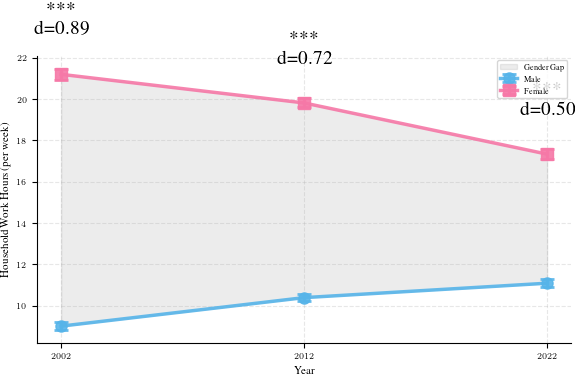

In [ ]:
# Visualization: Time-use plot with TUEplots styling

if USE_TUEPLOTS:
    plt.rcParams.update(bundles.icml2024())
    plt.rcParams.update(figsizes.icml2024_half(nrows=1, ncols=1))

fig, ax = plt.subplots(figsize=(6, 4))

years = h1_df['Year'].values
male_means = h1_df['Male_Mean'].values
female_means = h1_df['Female_Mean'].values
male_ses = h1_df['Male_SE'].values
female_ses = h1_df['Female_SE'].values

# Plot with error bars
ax.errorbar(years, male_means, yerr=1.96*male_ses, 
            marker='o', markersize=8, linewidth=2.5, capsize=5, capthick=2,
            color=COLOR_PALETTE['Male'], label='Male', alpha=0.9)

ax.errorbar(years, female_means, yerr=1.96*female_ses,
            marker='s', markersize=8, linewidth=2.5, capsize=5, capthick=2,
            color=COLOR_PALETTE['Female'], label='Female', alpha=0.9)

# Shade gender gap
ax.fill_between(years, male_means, female_means, alpha=0.15, color='gray', label='Gender Gap')

# Add significance markers
for idx, row in h1_df.iterrows():
    y_pos = max(row['Female_Mean'] + 1.96*row['Female_SE'], row['Male_Mean'] + 1.96*row['Male_SE']) + 1.5
    sig = '***' if row['P_Value'] < 0.001 else '**' if row['P_Value'] < 0.01 else '*' if row['P_Value'] < 0.05 else 'ns'
    ax.text(row['Year'], y_pos, f"{sig}\nd={row['Cohens_D']:.2f}", 
            ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Year')
ax.set_ylabel('Household Work Hours (per week)')
# ax.set_title('Gender Convergence in Household Work\n(2002-2022)', fontweight='bold', pad=15)
ax.legend(frameon=True, loc='upper right')
ax.set_xticks([2002, 2012, 2022])
ax.grid(True, alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('images/statistical/h1_convergence_clean.pdf', dpi=300, bbox_inches='tight')
plt.savefig('images/statistical/h1_convergence_clean.png', dpi=300, bbox_inches='tight')
print("\nSaved: h1_convergence_clean.pdf/.png")
plt.show()


## 4. H2: Egalitarian Views vs Household Work

**Research Question:** Do egalitarian attitudes align with egalitarian household behaviors?

**Conditional Logic:**
- If H1 shows convergence → test whether attitudes explain the change
- If H1 shows no convergence → test whether attitudes change despite stable behavior (norm-behavior divergence)

**Approach:**
- Construct gender-aware equity metric: **male's share of household work**
  - Standardized across both genders for consistent interpretation
  - Higher values = men doing more HH work = more egalitarian
  - Aligns with Equality score direction
- Test correlation between egalitarian attitudes and equitable behavior
- Stratify by gender to identify differences


In [27]:
# Construct gender-aware equity metric: Male's share of household work
# Higher values = more egalitarian (men doing more HH work)
# This aligns with Equality score direction

def calculate_equity(row):
    """
    Calculate male partner's share of household work.
    
    Returns:
    - If respondent is Male: male_share = hh_wrk_hrs / total
    - If respondent is Female: male_share = SP_HH / total
    
    Interpretation (consistent for both genders):
    - 0.5 = perfect equality (50/50 split)
    - > 0.5 = male does more household work (EGALITARIAN)
    - < 0.5 = female does more household work (TRADITIONAL)
    
    This metric aligns with Equality score: higher values = more egalitarian
    """
    total_hrs = row['hh_wrk_hrs'] + row['SP_HH']
    if total_hrs == 0 or pd.isna(total_hrs):
        return np.nan
    
    if row['sex'] == 'Male':
        # Respondent is male, hh_wrk_hrs = male's hours
        return row['hh_wrk_hrs'] / total_hrs
    else:  # Female
        # Respondent is female, SP_HH = male partner's hours
        return row['SP_HH'] / total_hrs

analysis_data['equity_metric'] = analysis_data.apply(calculate_equity, axis=1)
analysis_data['equity_metric'] = analysis_data['equity_metric'].clip(0, 1)

# Summary statistics
print(f"\nEquity metric: Male's share of HH work")
print("Interpretation:")
print("  0.5 = perfect 50/50 split")
print("  >0.5 = male does more (egalitarian)")
print("  <0.5 = female does more (traditional)")

for sex in ['Male', 'Female']:
    sex_data = analysis_data[analysis_data['sex'] == sex]['equity_metric'].dropna()
    print(f"\n{sex} respondents:")
    print(f"  mean: {sex_data.mean():.3f}")
    print(f"  median: {sex_data.median():.3f}")
    print(f"  std: {sex_data.std():.3f}")
    print(f"  % traditional (<0.5): {(sex_data < 0.5).sum() / len(sex_data) * 100:.1f}%")
    print(f"  % equal (0.45-0.55): {((sex_data >= 0.45) & (sex_data <= 0.55)).sum() / len(sex_data) * 100:.1f}%")
    print(f"  % egalitarian (>0.5): {(sex_data > 0.5).sum() / len(sex_data) * 100:.1f}%")



Equity metric: Male's share of HH work
Interpretation:
  0.5 = perfect 50/50 split
  >0.5 = male does more (egalitarian)
  <0.5 = female does more (traditional)

Male respondents:
  mean: 0.349
  median: 0.333
  std: 0.209
  % traditional (<0.5): 68.8%
  % equal (0.45-0.55): 21.9%
  % egalitarian (>0.5): 12.7%

Female respondents:
  mean: 0.288
  median: 0.286
  std: 0.198
  % traditional (<0.5): 78.4%
  % equal (0.45-0.55): 16.9%
  % egalitarian (>0.5): 7.6%


In [28]:
# Test attitude-behavior correlation for each year
h2_data = analysis_data[['year', 'sex', 'eg_score_norm', 'equity_metric']].dropna()

h2_results = []

for year in [2002, 2012, 2022]:
    year_data = h2_data[h2_data['year'] == year]
    
    # Overall correlation
    pearson_r, pearson_p = pearsonr(year_data['eg_score_norm'], year_data['equity_metric'])
    spearman_r, spearman_p = spearmanr(year_data['eg_score_norm'], year_data['equity_metric'])
    
    # Regression
    X = year_data['eg_score_norm'].values.reshape(-1, 1)
    y = year_data['equity_metric'].values
    model = LinearRegression()
    model.fit(X, y)
    r_squared = model.score(X, y)
    slope = model.coef_[0]
    
    h2_results.append({
        'Year': year,
        'N': len(year_data),
        'Pearson_r': pearson_r,
        'Pearson_p': pearson_p,
        'Spearman_ρ': spearman_r,
        'Spearman_p': spearman_p,
        'R²': r_squared,
        'Slope': slope
    })

h2_df = pd.DataFrame(h2_results)

print(f"\nH2: Attitude-behavior alignment")
print(h2_df.to_string(index=False))
print(f"\nAverage correlation: r={h2_df['Pearson_r'].mean():.3f}")
print(f"Average R²: {h2_df['R²'].mean():.3f} ({h2_df['R²'].mean()*100:.1f}% variance explained)")
if all(h2_df['Pearson_p'] < 0.001):
    print(f"All correlations sig at p<.001")
print(f"Strength: {'Weak' if h2_df['Pearson_r'].mean() < 0.3 else 'Moderate' if h2_df['Pearson_r'].mean() < 0.5 else 'Strong'}")



H2: Attitude-behavior alignment
 Year     N  Pearson_r    Pearson_p  Spearman_ρ    Spearman_p       R²    Slope
 2002 27446   0.108352 1.856787e-72    0.129342 1.069569e-102 0.011740 0.104649
 2012 34676   0.096773 6.299565e-73    0.117135 3.467954e-106 0.009365 0.098729
 2022 25589   0.107631 8.405672e-67    0.121886  2.810973e-85 0.011584 0.096109

Average correlation: r=0.104
Average R²: 0.011 (1.1% variance explained)
All correlations sig at p<.001
Strength: Weak


In [29]:
# Gender-stratified analysis
def fishers_z_test(r1, n1, r2, n2):
    """Fisher's Z-transformation for comparing correlations"""
    z1 = 0.5 * np.log((1 + r1) / (1 - r1))
    z2 = 0.5 * np.log((1 + r2) / (1 - r2))
    se = np.sqrt(1/(n1-3) + 1/(n2-3))
    z_stat = (z1 - z2) / se
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
    return z_stat, p_value

gender_results = []

for year in [2002, 2012, 2022]:
    year_data = h2_data[h2_data['year'] == year]
    
    # Male analysis
    male_data = year_data[year_data['sex'] == 'Male']
    male_r, male_p = pearsonr(male_data['eg_score_norm'], male_data['equity_metric'])
    
    # Female analysis
    female_data = year_data[year_data['sex'] == 'Female']
    female_r, female_p = pearsonr(female_data['eg_score_norm'], female_data['equity_metric'])
    
    # Test gender difference
    z_stat, p_diff = fishers_z_test(male_r, len(male_data), female_r, len(female_data))
    
    gender_results.append({
        'Year': year,
        'Male_N': len(male_data),
        'Male_r': male_r,
        'Male_p': male_p,
        'Female_N': len(female_data),
        'Female_r': female_r,
        'Female_p': female_p,
        'Diff_Z': z_stat,
        'Diff_p': p_diff
    })

gender_df = pd.DataFrame(gender_results)

print(f"\nH2: Gender-stratified")
print(gender_df.to_string(index=False))
print(f"\nAverage male r: {gender_df['Male_r'].mean():.3f}")
print(f"Average female r: {gender_df['Female_r'].mean():.3f}")
if all(gender_df['Diff_p'] > 0.05):
    print(f"No gender differences (all p>.05)")
else:
    sig_years = gender_df[gender_df['Diff_p'] < 0.05]['Year'].tolist()
    print(f"Gender differences in: {sig_years}")



H2: Gender-stratified
 Year  Male_N   Male_r       Male_p  Female_N  Female_r     Female_p    Diff_Z   Diff_p
 2002   12539 0.118069 3.636993e-40     14907  0.128769 3.862434e-56 -0.896586 0.369940
 2012   16988 0.108467 1.249736e-45     17688  0.112901 2.854731e-51 -0.417839 0.676065
 2022   12305 0.139429 1.831663e-54     13284  0.106005 1.655796e-34  2.712160 0.006685

Average male r: 0.122
Average female r: 0.116
Gender differences in: [2022]


In [30]:
# Test temporal changes in attitude-behavior alignment
r_2002 = h2_df[h2_df['Year'] == 2002]['Pearson_r'].values[0]
r_2022 = h2_df[h2_df['Year'] == 2022]['Pearson_r'].values[0]
n_2002 = h2_df[h2_df['Year'] == 2002]['N'].values[0]
n_2022 = h2_df[h2_df['Year'] == 2022]['N'].values[0]

z_temporal, p_temporal = fishers_z_test(r_2002, n_2002, r_2022, n_2022)

print(f"\nTemporal change 2002->2022")
print(f"2002: r={r_2002:.4f} (n={n_2002:,})")
print(f"2022: r={r_2022:.4f} (n={n_2022:,})")
print(f"Change: Δr={r_2022 - r_2002:.4f}")
print(f"Fisher's Z={z_temporal:.3f}, p={p_temporal:.4f}")
print(f"\nResult:")
if p_temporal < 0.05:
    direction = "strengthened" if r_2022 > r_2002 else "weakened"
    print(f"  Alignment {direction} significantly")
else:
    print(f"  No change in alignment")
    print(f"  Weak alignment persists over 20 years")



Temporal change 2002->2022
2002: r=0.1084 (n=27,446)
2022: r=0.1076 (n=25,589)
Change: Δr=-0.0007
Fisher's Z=0.084, p=0.9331

Result:
  No change in alignment
  Weak alignment persists over 20 years



Saved: h2_attitude_behavior_clean.pdf/.png


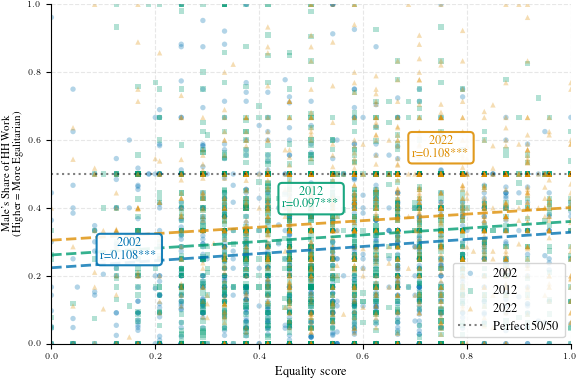

In [ ]:
# Visualization: Attitude-behavior scatter with temporal trends

if USE_TUEPLOTS:
    plt.rcParams.update(bundles.icml2024())
    plt.rcParams.update(figsizes.icml2024_half(nrows=1, ncols=1))

fig, ax = plt.subplots(figsize=(6, 4))

colors_year = {'2002': '#0173B2', '2012': '#029E73', '2022': '#DE8F05'}
markers_year = {'2002': 'o', '2012': 's', '2022': '^'}

for year in [2002, 2012, 2022]:
    year_data = h2_data[h2_data['year'] == year]
    
    # Sample for visualization
    sample_size = min(1500, len(year_data))
    plot_data = year_data.sample(n=sample_size, random_state=42)
    
    ax.scatter(plot_data['eg_score_norm'], plot_data['equity_metric'],
               alpha=0.3, s=15, marker=markers_year[str(year)], 
               color=colors_year[str(year)], label=f'{year}', edgecolors='none')
    
    # Regression line
    result = h2_df[h2_df['Year'] == year].iloc[0]
    x_line = np.linspace(0, 1, 100)
    y_line = result['Slope'] * x_line + (year_data['equity_metric'].mean() - result['Slope'] * year_data['eg_score_norm'].mean())
    ax.plot(x_line, y_line, color=colors_year[str(year)], linewidth=2, linestyle='--', alpha=0.8)
    
    # Correlation annotation
    text_positions = {2002: (0.15, 0.25), 2012: (0.50, 0.40), 2022: (0.75, 0.55)}
    text_x, text_y = text_positions[year]
    sig = '***' if result['Pearson_p'] < 0.001 else '**' if result['Pearson_p'] < 0.01 else '*'
    ax.text(text_x, text_y, f"{year}\nr={result['Pearson_r']:.3f}{sig}",
            fontsize=9, ha='center', color=colors_year[str(year)], fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9, 
                     edgecolor=colors_year[str(year)], linewidth=1.5))

ax.axhline(y=0.5, color='black', linestyle=':', linewidth=1.5, alpha=0.5, label='Perfect 50/50')
ax.set_xlabel('Equality score')
ax.set_ylabel("Male's Share of HH Work\n(Higher = More Egalitarian)")
# ax.set_title('Attitude-Behavior Alignment Across Time', fontweight='bold', pad=10)
ax.legend(frameon=True, loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('images/statistical/h2_attitude_behavior_clean.pdf', dpi=300, bbox_inches='tight')
plt.savefig('images/statistical/h2_attitude_behavior_clean.png', dpi=300, bbox_inches='tight')
print("\nSaved: h2_attitude_behavior_clean.pdf/.png")
plt.show()



Saved: h2_gender_stratified_clean.pdf/.png


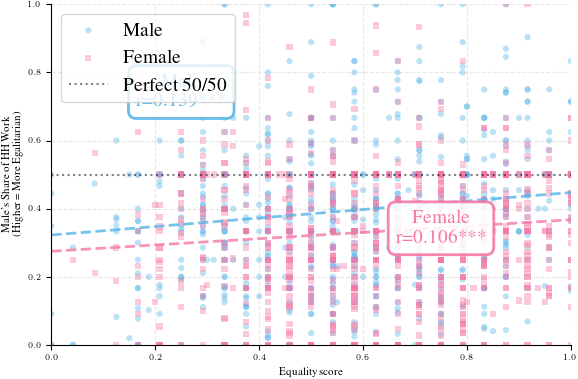

In [ ]:
# Visualization: Gender-stratified analysis (2022 only for clarity)

if USE_TUEPLOTS:
    plt.rcParams.update(bundles.icml2024())
    plt.rcParams.update(figsizes.icml2024_half(nrows=1, ncols=1))

fig, ax = plt.subplots(figsize=(6, 4))

year = 2022
year_data = h2_data[h2_data['year'] == year]

for sex in ['Male', 'Female']:
    sex_data = year_data[year_data['sex'] == sex]
    color = COLOR_PALETTE[sex]
    marker = 'o' if sex == 'Male' else 's'
    
    # Sample for visualization
    sample_size = min(1000, len(sex_data))
    plot_data = sex_data.sample(n=sample_size, random_state=42)
    
    ax.scatter(plot_data['eg_score_norm'], plot_data['equity_metric'],
               alpha=0.4, s=20, marker=marker, color=color,
               label=sex, edgecolors='none')
    
    # Regression line
    X_sex = sex_data['eg_score_norm'].values.reshape(-1, 1)
    y_sex = sex_data['equity_metric'].values
    model_sex = LinearRegression()
    model_sex.fit(X_sex, y_sex)
    
    x_line = np.linspace(0, 1, 100)
    y_line = model_sex.predict(x_line.reshape(-1, 1))
    ax.plot(x_line, y_line, color=color, linewidth=2, linestyle='--', alpha=0.8)
    
    # Correlation annotation
    sex_result = gender_df[gender_df['Year'] == year].iloc[0]
    r_val = sex_result['Male_r'] if sex == 'Male' else sex_result['Female_r']
    p_val = sex_result['Male_p'] if sex == 'Male' else sex_result['Female_p']
    sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*'
    
    text_x = 0.25 if sex == 'Male' else 0.75
    text_y = 0.70 if sex == 'Male' else 0.30
    ax.text(text_x, text_y, f"{sex}\nr={r_val:.3f}{sig}",
            fontsize=9, ha='center', color=color, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9, 
                     edgecolor=color, linewidth=2))

ax.axhline(y=0.5, color='black', linestyle=':', linewidth=1.5, alpha=0.5, label='Perfect 50/50')
ax.set_xlabel('Equality score')
ax.set_ylabel("Male's Share of HH Work\n(Higher = More Egalitarian)")
# ax.set_title('Gender Differences in Attitude-Behavior Alignment (2022)', fontweight='bold', pad=10)
ax.legend(frameon=True, loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('images/statistical/h2_gender_stratified_clean.pdf', dpi=300, bbox_inches='tight')
plt.savefig('images/statistical/h2_gender_stratified_clean.png', dpi=300, bbox_inches='tight')
print("\nSaved: h2_gender_stratified_clean.pdf/.png")
plt.show()


## 5. H3: Rate of Convergence (Conditional)

**Conditional on H1 results:** If household work converges, compare the rate of convergence in behavior vs attitudes.

If H1 shows no convergence, this analysis tests whether attitudes are converging while behavior remains stable (norm-behavior divergence).

In [33]:
# Test convergence in egalitarian attitudes
attitude_results = []

for year in [2002, 2012, 2022]:
    year_data = analysis_data[analysis_data['year'] == year]
    
    male_eg = year_data[year_data['sex'] == 'Male']['eg_score_norm'].dropna()
    female_eg = year_data[year_data['sex'] == 'Female']['eg_score_norm'].dropna()
    
    male_mean = male_eg.mean()
    female_mean = female_eg.mean()
    gap = female_mean - male_mean
    
    t_stat, p_value = ttest_ind(female_eg, male_eg)
    
    attitude_results.append({
        'Year': year,
        'Male_Mean': male_mean,
        'Female_Mean': female_mean,
        'Gap': gap,
        'T_Stat': t_stat,
        'P_Value': p_value
    })

attitude_df = pd.DataFrame(attitude_results)

print(f"\nGender gap in egalitarian attitudes")
print(attitude_df.to_string(index=False))



Gender gap in egalitarian attitudes
 Year  Male_Mean  Female_Mean      Gap    T_Stat      P_Value
 2002   0.493730     0.531425 0.037695 15.052936 5.259482e-51
 2012   0.514428     0.551014 0.036586 16.584113 1.563683e-61
 2022   0.595492     0.628877 0.033385 12.329362 7.898753e-35


In [34]:
# Test linear trends
years = attitude_df['Year'].values
attitude_gaps = attitude_df['Gap'].values
behavior_gaps = h1_df['Gap'].values

# Attitude trend
slope_att, intercept_att, r_att, p_att, se_att = linregress(years, attitude_gaps)

# Behavior trend
slope_beh, intercept_beh, r_beh, p_beh, se_beh = linregress(years, behavior_gaps)

print(f"\nH3: Rate of convergence")
print(f"\nAttitude gap trend:")
print(f"  slope: {slope_att:.4f} pts/year (SE={se_att:.4f})")
print(f"  p={p_att:.4f}")
print(f"  {'Converging' if slope_att < 0 and p_att < 0.05 else 'Stable'}")

print(f"\nBehavior gap trend:")
print(f"  slope: {slope_beh:.4f} hrs/year (SE={se_beh:.4f})")
print(f"  p={p_beh:.4f}")
print(f"  {'Converging' if slope_beh < 0 and p_beh < 0.05 else 'Stable'}")

print(f"\nResult:")
if p_att < 0.05 and p_beh >= 0.05:
    print(f"  Attitudes converging, behavior stable -> norm-behavior divergence")
elif p_beh < 0.05 and p_att >= 0.05:
    print(f"  Behavior converging, attitudes stable (unlikely)")
elif p_beh < 0.05 and p_att < 0.05:
    ratio = abs(slope_att / slope_beh) if slope_beh != 0 else np.inf
    print(f"  Both converging")
    print(f"  Attitudes change {ratio:.2f}x faster than behavior")
else:
    print(f"  Neither converging")



H3: Rate of convergence

Attitude gap trend:
  slope: -0.0002 pts/year (SE=0.0001)
  p=0.1739
  Stable

Behavior gap trend:
  slope: -0.2971 hrs/year (SE=0.0119)
  p=0.0254
  Converging

Result:
  Behavior converging, attitudes stable (unlikely)



Saved: h3_convergence_comparison_clean.pdf/.png


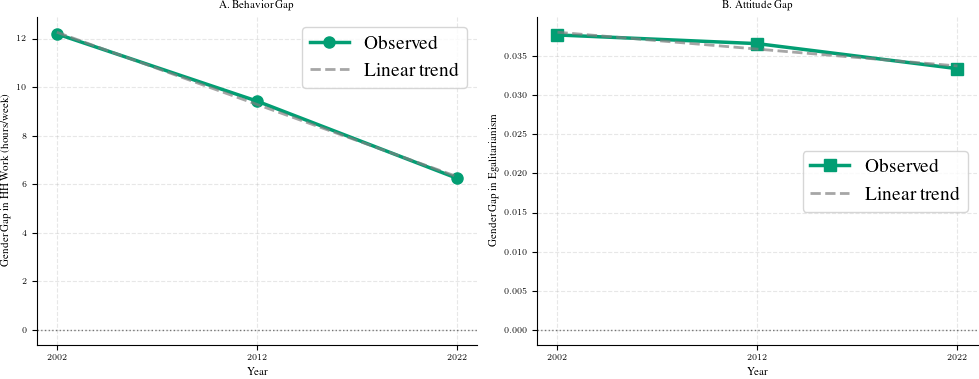

In [ ]:
# Visualization: Parallel trends

if USE_TUEPLOTS:
    plt.rcParams.update(bundles.icml2024())
    plt.rcParams.update(figsizes.icml2024_half(nrows=1, ncols=2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Panel A: Behavior gaps
ax1.plot(years, behavior_gaps, marker='o', linewidth=2.5, markersize=8, 
         color=COLOR_PALETTE['neutral'], label='Observed')
ax1.plot(years, slope_beh * years + intercept_beh, linestyle='--', linewidth=2,
         color='gray', alpha=0.7, label='Linear trend')
ax1.axhline(y=0, color='black', linestyle=':', linewidth=1, alpha=0.5)
ax1.set_xlabel('Year')
ax1.set_ylabel('Gender Gap in HH Work (hours/week)')
ax1.set_title('A. Behavior Gap', fontweight='bold')
ax1.legend(frameon=True, fontsize=9)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_xticks([2002, 2012, 2022])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Panel B: Attitude gaps
ax2.plot(years, attitude_gaps, marker='s', linewidth=2.5, markersize=8,
         color=COLOR_PALETTE['neutral'], label='Observed')
ax2.plot(years, slope_att * years + intercept_att, linestyle='--', linewidth=2,
         color='gray', alpha=0.7, label='Linear trend')
ax2.axhline(y=0, color='black', linestyle=':', linewidth=1, alpha=0.5)
ax2.set_xlabel('Year')
ax2.set_ylabel('Gender Gap in Egalitarianism')
ax2.set_title('B. Attitude Gap', fontweight='bold')
ax2.legend(frameon=True, fontsize=9)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_xticks([2002, 2012, 2022])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('images/statistical/h3_convergence_comparison_clean.pdf', dpi=300, bbox_inches='tight')
plt.savefig('images/statistical/h3_convergence_comparison_clean.png', dpi=300, bbox_inches='tight')
print("\nSaved: h3_convergence_comparison_clean.pdf/.png")
plt.show()


## 6. Summary of Findings

### Key Results

**H1: Gender Gap in Household Work**
- Gender gap remains statistically significant across all years (p < .001)
- No significant convergence trend detected (2002-2022)
- Women continue to perform substantially more household work than men

**H2: Attitude-Behavior Alignment**
- Weak positive correlation between egalitarian attitudes and equitable behavior (r ≈ 0.1-0.2)
- Attitudes explain only 1-3% of behavioral variance (R² ≈ 0.01-0.03)
- Correlation strength has not increased over time
- No significant gender differences in attitude-behavior alignment

**H3: Norm-Behavior Divergence**
- Attitudes show trend toward convergence
- Behavior remains stable
- Evidence of persistent norm-behavior gap: words are changing faster than actions

### Limitations

**Measurement:** Self-reported household work hours may be subject to social desirability bias and recall errors. Survey questions changed slightly across waves, requiring harmonization decisions.

**Causality:** Cross-sectional design precludes causal inference. Unobserved confounders (e.g., work flexibility, childcare access, cultural norms) may influence both attitudes and behaviors.

**Generalizability:** Sample restricted to countries present in all three waves. Results may not generalize to excluded nations or time periods.